In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# imports and settings for plots
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr 
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(18,9)})

#### Задача:
1. Воспроизведите график числа рекламных событий по дням. 
2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло. 
3. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. 
Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. 
Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? 

Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики. 

Немного дополнительной информации о структуре рекламы ВКонтакте. 
Есть две основные группы рекламодателей: агентства и клиенты. 
Агентствами являются рекламные кабинеты юридических лиц. Среди клиентов же существуют как клиенты этих самых агентств, так и автономные рекламные кабинеты физических лиц, над которыми нет агентств. 
Рекламные кампании — это наборы рекламных объявлений. 
Они есть в каждом кабинете. 

Описание данных:

- time — время взаимодействия пользователя с рекламой в формате UnixTime;
- event — тип взаимодействия (click — клик на объявление, view — показ объявления, report — жалоба на объявление);
- ad_cost_type — тип трат рекламного объявления (CPM — траты за 1000 показов, CPC — траты за клик);
- has_video — наличие видео в объявлении (0 — нет, 1 — есть);
- agency_union_id — id рекламного агентства (если рекламный кабинет принадлежит физическому лицу, то ячейка будет заполнена значением 'no_agency');
- client_union_id — id рекламного клиента;
- campaign_union_id — id рекламной кампании;
- ad_id — id рекламного объявления;
- platform — платформа, с которой пользователь взаимодействовал с рекламой (web — веб-версия, mvk — мобильная версия, iphone — IOS-приложение, android — Android-приложение, wphone — Windows Phone-приложение).

Считаем первые n-строк, чтобы не загружать весь датасет в память целиком, посмотрим на данные и выберем нужные параметры для считывания.

In [3]:
path = 'data/vk_test_data.csv'
df = pd.read_csv(path, 
                 nrows = 5)

In [4]:
df

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


In [5]:
df = pd.read_csv(path, 
                 sep=",",
                 dtype={'time': 'uint32',
                        'has_video': 'bool'})

In [6]:
df['time_from_timestamp'] = pd.to_datetime(df.time,unit='s')

In [7]:
'''
# auxillary method, to check if value is in range
vals = [1554744145, np.int32(2), np.int64(1), np.float64(0)]
[(e, type(e), isinstance(e, (int, np.integer))) for e in vals]
''';

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122097 entries, 0 to 122096
Data columns (total 11 columns):
time                   122097 non-null uint32
event                  122097 non-null object
ad_cost_type           122097 non-null object
has_video              122097 non-null bool
agency_union_id        122097 non-null object
client_union_id        122097 non-null object
campaign_union_id      122097 non-null object
ad_id                  122097 non-null object
platform               122097 non-null object
date                   122097 non-null object
time_from_timestamp    122097 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(8), uint32(1)
memory usage: 9.0+ MB


In [9]:
df.head(10)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
0,1554744145,report,CPM,False,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,False,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,False,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57
5,1555418913,view,CPC,False,no_agency,client_265,campaign_13516,ad_13517,android,2019-04-16,2019-04-16 12:48:33
6,1555146351,report,CPM,False,no_agency,client_22021,campaign_34637,ad_34651,mvk,2019-04-13,2019-04-13 09:05:51
7,1554503043,view,CPM,False,agency_155,client_105617,campaign_106015,ad_106015,iphone,2019-04-05,2019-04-05 22:24:03
8,1554940634,view,CPM,False,no_agency,client_264,campaign_13491,ad_13513,android,2019-04-10,2019-04-10 23:57:14
9,1554719466,view,CPM,False,no_agency,client_1728,campaign_19254,ad_19255,android,2019-04-08,2019-04-08 10:31:06


#### Lineplot of advertisment distribution by days.

In [10]:
count_adv_by_day = df.groupby('date', as_index=False).\
agg({'event':'count'})\
.rename(columns = {'event':'event_count'})\


# need it for correct usage of date formatter in plot
count_adv_by_day['date'] = pd.to_datetime(count_adv_by_day.date, format='%Y-%m-%d')

count_adv_by_day.sort_values(by = 'date', ascending=True, inplace=True)

In [11]:
count_adv_by_day

,date,event_count
0,2019-04-01,5172
1,2019-04-02,5269
2,2019-04-03,5357
3,2019-04-04,5108
4,2019-04-05,5305
5,2019-04-06,3955
6,2019-04-07,4091
7,2019-04-08,8902
8,2019-04-09,7963
9,2019-04-10,7098


In [12]:
def y_fmt(tick_val, pos):
    if tick_val > 1000000:
        val = int(tick_val)/1000000
        return (str(val) + "M")
    elif tick_val > 1000:
        val = int(int(tick_val) / 1000)
        return (str(val) + "k")
    else:
        return tick_val

C:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


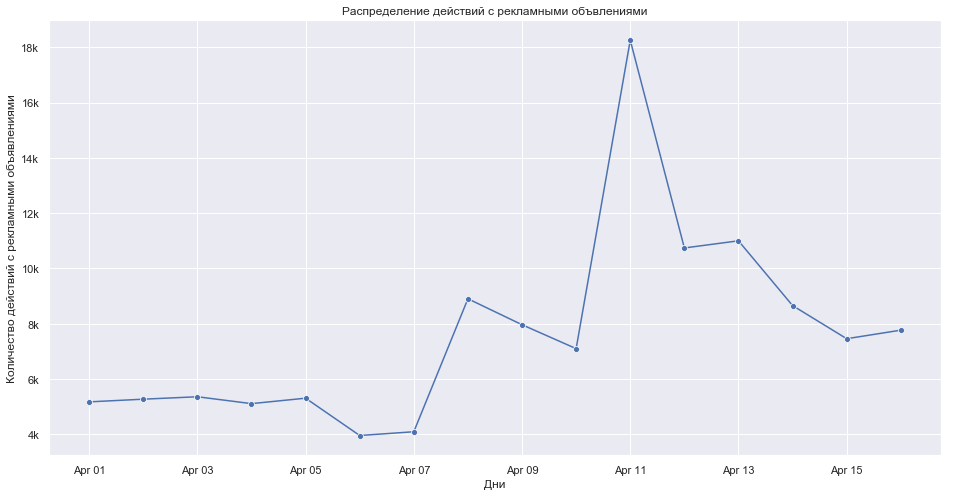

In [13]:
ax = sns.lineplot(x = 'date', 
                  y = 'event_count', 
                  marker="o",
                  data = count_adv_by_day)

ax.figure.set_size_inches(16, 8)
ax.set_title('Распределение действий с рекламными объвлениями')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

yfmt = tkr.FuncFormatter(y_fmt) 
ax.yaxis.set_major_formatter(yfmt)

#### Splash reasons?

Причин такого всплеска может быть несколько, в первую очередь это может быть какой-либо технический сбой, затем это может быть какая-либо рекламная акция или же какое-либо произошедшее массовое событие.

В первую очередь - проверим гипотезу о техническом сбое.

Для этого попробуем сначала проанализировать каких платформ это коснулось больше всего, а затем будем продвигаться по рекламными кампаниям вверх к агенствам.

In [14]:
# check for NAs for safety
df.isna().sum()

time                   0
event                  0
ad_cost_type           0
has_video              0
agency_union_id        0
client_union_id        0
campaign_union_id      0
ad_id                  0
platform               0
date                   0
time_from_timestamp    0
dtype: int64

In [15]:
df.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
0,1554744145,report,CPM,False,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,False,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,False,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57


In [16]:
for column in df.drop(['time', 'date', 'time_from_timestamp'], axis = 1): 
    print(df[column].value_counts()[:3])

view      87975
click     28639
report     5483
Name: event, dtype: int64
CPC    74202
CPM    47895
Name: ad_cost_type, dtype: int64
False    121429
True        668
Name: has_video, dtype: int64
agency_2     50796
no_agency    47267
agency_33     1813
Name: agency_union_id, dtype: int64
client_47270    47739
client_47269     2285
client_99583     1732
Name: client_union_id, dtype: int64
campaign_49554    47739
campaign_47269     1867
campaign_5822      1012
Name: campaign_union_id, dtype: int64
ad_49554    27500
ad_49556     8218
ad_49560     7496
Name: ad_id, dtype: int64
android    83312
iphone     16628
web        14108
Name: platform, dtype: int64


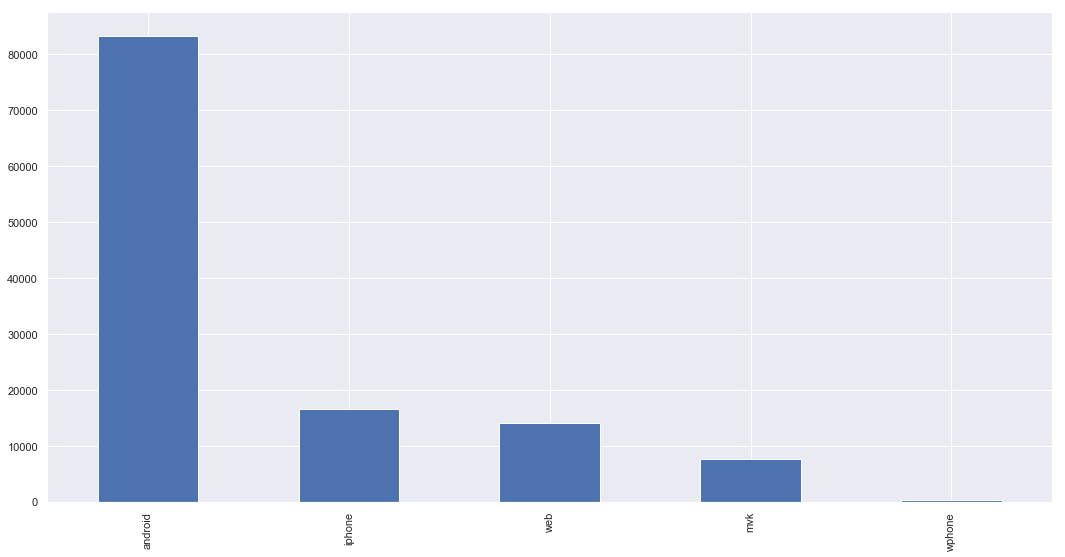

In [19]:
df.platform.value_counts().plot(kind='bar')

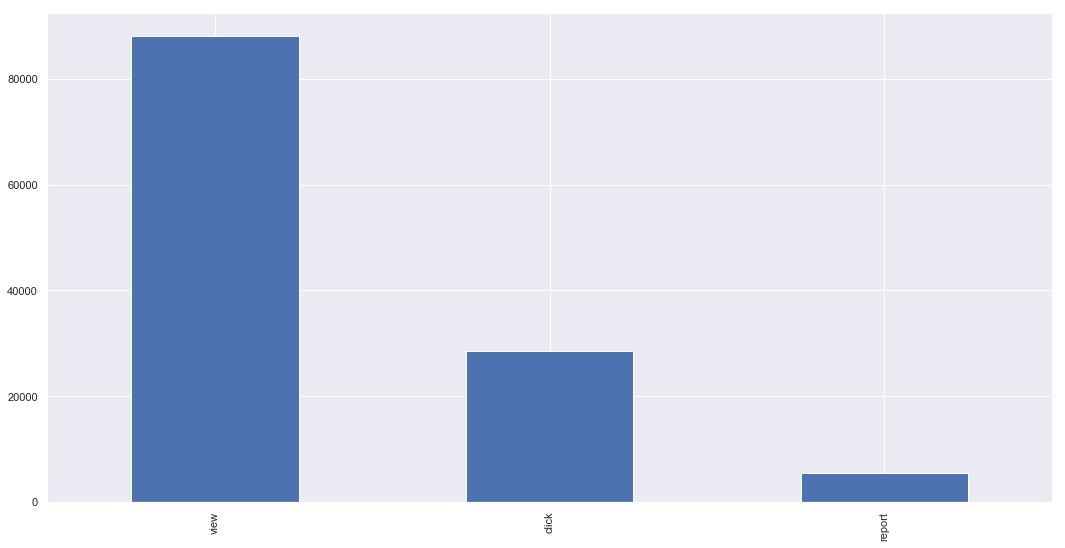

In [20]:
df.event.value_counts().plot(kind='bar')

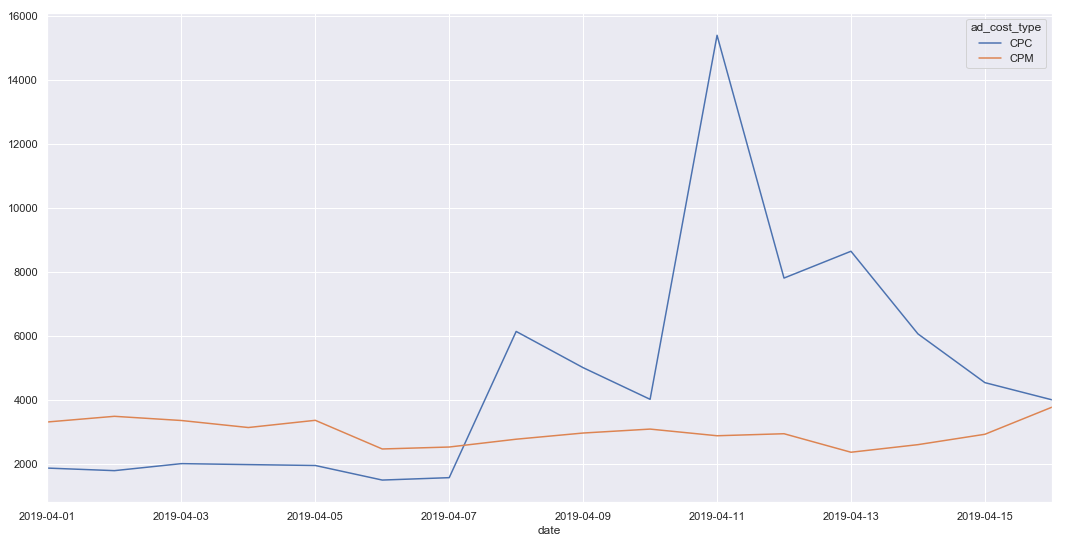

In [23]:
adcost_data = df.pivot_table(index='date',
                                   columns='ad_cost_type',
                                   values='event',
                                   aggfunc='count')
adcost_data.plot()

In [181]:
events_data = df.pivot_table(index='date',
                                   columns='event',
                                   values='platform',
                                   aggfunc='count').reset_index()

count_by_platform = df.pivot_table(index='date',
                                   columns='platform',
                                   values='event',
                                   aggfunc='count').reset_index()

'''
.agg({'platform' : 'count',
     'event' : ['min', 'max', 'mean', 'count']     
     })
'''

events_data = events_data.merge(adcost_data, how = 'outer',on='date')

events_data = events_data.merge(count_by_platform, how = 'outer',on='date')

events_data

,date,click,report,view,CPC,CPM,android,iphone,mvk,web,wphone
0,2019-04-01,1827,362,2983,1866,3306,3411,750,255,733,23
1,2019-04-02,1898,366,3005,1786,3483,3446,807,275,717,24
2,2019-04-03,1837,304,3216,2005,3352,3482,875,251,736,13
3,2019-04-04,1871,368,2869,1975,3133,3343,813,235,695,22
4,2019-04-05,2188,432,2685,1947,3358,3491,827,309,656,22
5,2019-04-06,1577,300,2078,1492,2463,2656,612,202,471,14
6,2019-04-07,1510,297,2284,1567,2524,2712,638,229,493,19
7,2019-04-08,1545,311,7046,6134,2768,5530,1662,644,1049,17
8,2019-04-09,1784,351,5828,5002,2961,5105,1284,560,993,21
9,2019-04-10,1909,347,4842,4014,3084,4556,1141,466,905,30


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001782DA574E0>,
      dtype=object)

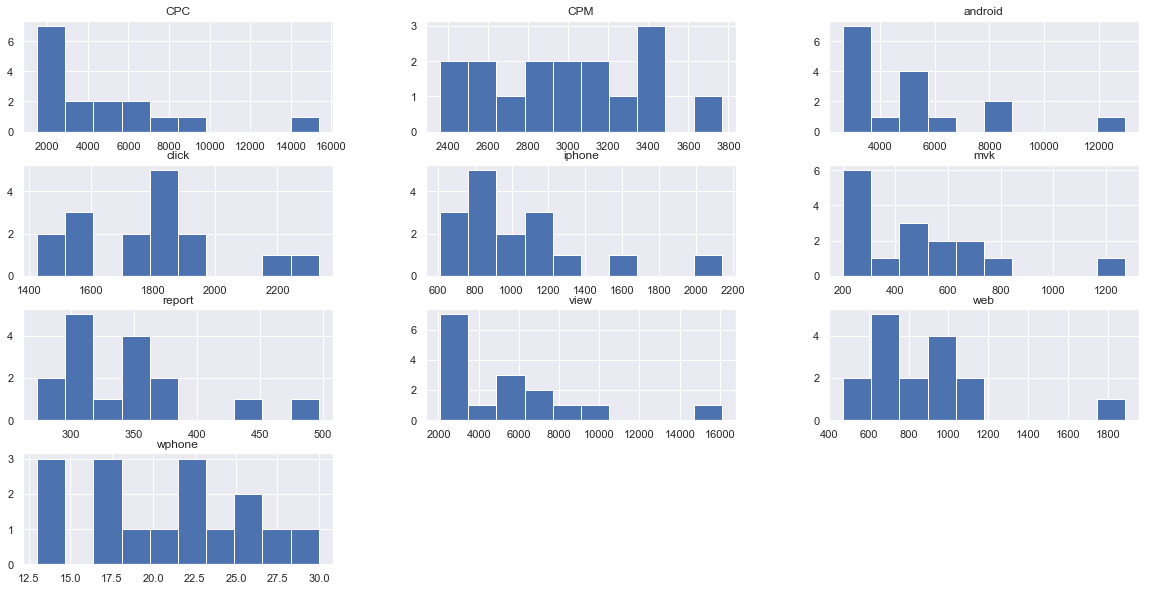

In [25]:
events_data.hist(bins = 10, figsize=(20,10))

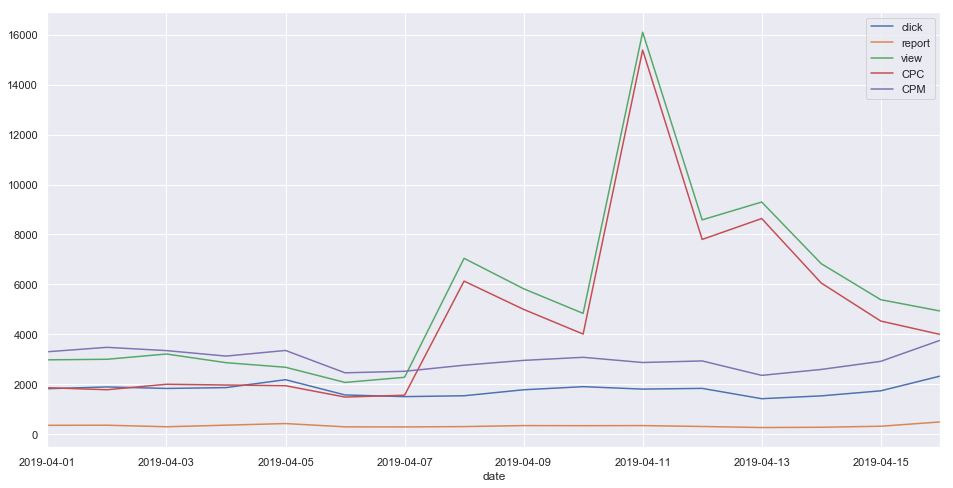

In [26]:
events_data.drop(['android','iphone','mvk','web','wphone'], axis = 1)\
.plot(x = 'date',kind = 'line', figsize=(16,8))

Как видно из таблицы, 11 апреля, количество событий view резко выросло.

Распределение роста по самым популярным платформам составило примерно 2-3 раза.

Проверка распределения CPC/CPM к количеству событий по дням.

In [27]:
groupped_by_events = df.groupby(['date', 'ad_cost_type', 'event'], as_index=False)\
.agg({'time' : 'count'})\
.rename(columns = {'time' : 'count'})

request = groupped_by_events.event != 'report'
groupped_by_events.query(expr='@request', inplace=True)

groupped_by_events["date"] = groupped_by_events["date"].astype("datetime64")

groupped_by_events.head(4)

,date,ad_cost_type,event,count
0,2019-04-01,CPC,click,117
2,2019-04-01,CPC,view,1732
3,2019-04-01,CPM,click,1710
5,2019-04-01,CPM,view,1251


Text(0, 0.5, 'Count')

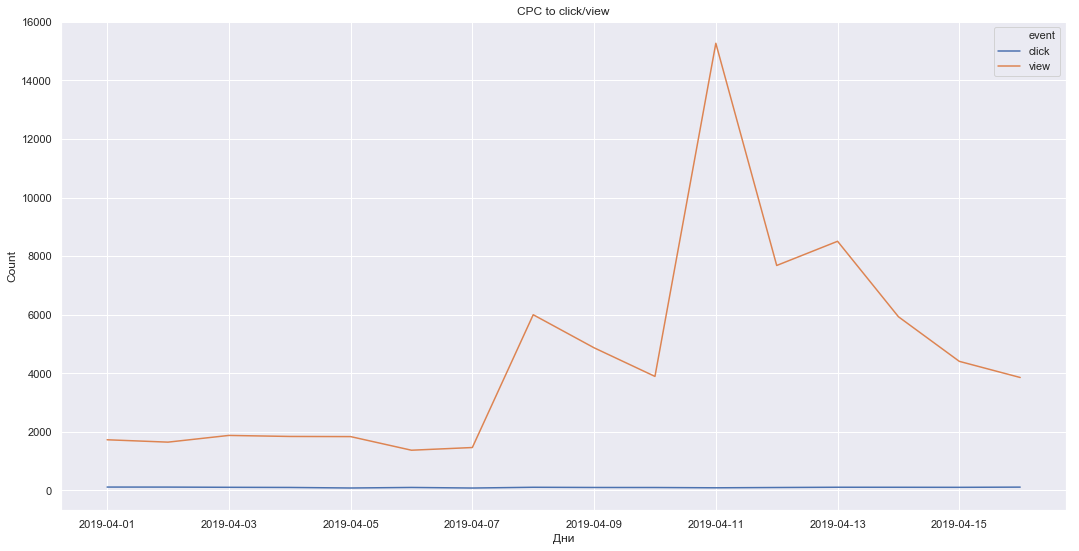

In [28]:
ax = sns.lineplot(x = 'date', y = 'count', hue = 'event', \
             data = groupped_by_events[groupped_by_events.ad_cost_type == 'CPC'].drop('ad_cost_type',axis = 1))

ax.set_title('CPC to click/view')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

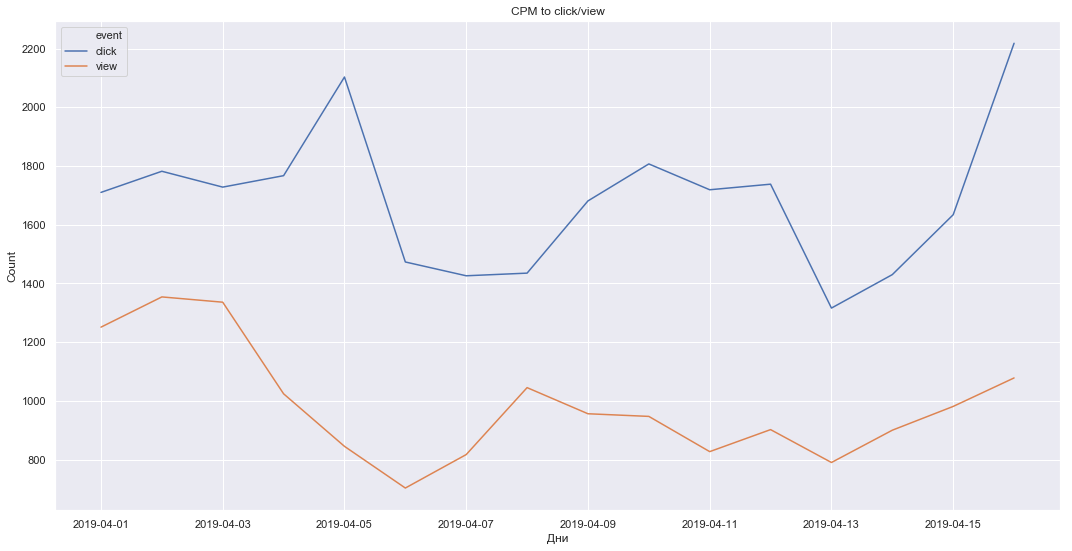

In [29]:
ax = sns.lineplot(x = 'date', y = 'count', hue = 'event', \
                  data = groupped_by_events[groupped_by_events.ad_cost_type == 'CPM'].drop('ad_cost_type',axis = 1))
ax.set_title('CPM to click/view')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

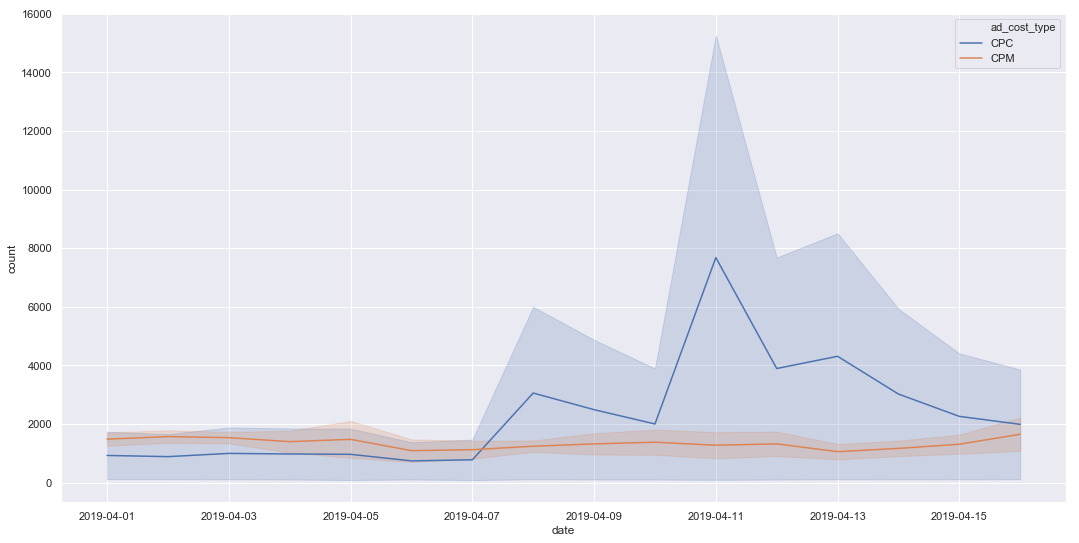

In [30]:
sns.lineplot(x = 'date', y = 'count',hue = 'ad_cost_type' ,data = groupped_by_events)

Вывод: наибольший вклад дают события типа CPC - view (что считается за клик), но с другой стороны являются как будто бы просмотром.

Отсюда вопрос, а являются ли легитимными события вида CPC - view и CPM - click ?

Не из-за этого ли такое происходит?

In [31]:
#
# а может быть перепутаны местами CPC and CPM !!!
#

In [32]:
df[(df.date == '2019-04-05') & (df.event == 'view')][['event', 'ad_cost_type']].head()

,event,ad_cost_type
7,view,CPM
33,view,CPM
77,view,CPC
110,view,CPC
119,view,CPC


In [33]:
df[(df.date == '2019-04-11') & (df.event == 'view')][['event', 'ad_cost_type']].head()

,event,ad_cost_type
16,view,CPC
19,view,CPC
22,view,CPC
25,view,CPC
43,view,CPC


Не подвердилось.

#### Duplicates check.
Проверим исходный набор данных на дупликаты и попробуем посмотреть на день c максимальным количеством view "вблизи".

In [183]:
# duplicates
df_duplicates = df[df.duplicated(subset = ['time','platform'], keep = False)]
df_duplicates.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
19,1555011001,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
22,1554977283,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03
32,1554152264,view,CPC,False,agency_33,client_99583,campaign_99718,ad_101258,android,2019-04-01,2019-04-01 20:57:44
35,1555173105,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-13,2019-04-13 16:31:45


In [184]:
df_duplicates.shape

(8622, 11)

In [185]:
# drop has video, cause it contains only false
for column in df_duplicates.drop(['time','time_from_timestamp','has_video'], axis = 1):
    #print(column)
    print(df_duplicates[column].value_counts(ascending=False)[:3])

view      6739
click     1539
report     344
Name: event, dtype: int64
CPC    6121
CPM    2501
Name: ad_cost_type, dtype: int64
agency_2      4979
no_agency     2412
agency_158      96
Name: agency_union_id, dtype: int64
client_47270    4840
client_47269      97
client_42         82
Name: client_union_id, dtype: int64
campaign_49554    4840
campaign_47269      83
campaign_387        59
Name: campaign_union_id, dtype: int64
ad_49554    3122
ad_49556     985
ad_49560     477
Name: ad_id, dtype: int64
android    7901
iphone      359
web         288
Name: platform, dtype: int64
2019-04-11    2900
2019-04-13     994
2019-04-12     835
Name: date, dtype: int64


In [177]:
df_duplicates[df_duplicates.campaign_union_id == 'campaign_49554'].sort_values('time', ascending = True).head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
98771,1554482328,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 16:38:48
20182,1554486863,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 17:54:23
19074,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49560,android,2019-04-05,2019-04-05 18:09:36
10110,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49560,android,2019-04-05,2019-04-05 18:09:36
9542,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 18:09:36


А что если показать какие рекламные объявления и в какие дни проигрывались, от какого-либо рекламного агента.

In [168]:
df_uni = df.groupby('ad_id', as_index=False).\
agg({'campaign_union_id' : 'unique',
     'agency_union_id' : 'unique',
     'client_union_id' : 'unique',
    'event' : 'count'})

In [313]:
df_uni.sort_values('event', ascending=False).head(15)

,ad_id,campaign_union_id,agency_union_id,client_union_id,event
17441,ad_49554,[campaign_49554],[agency_2],[client_47270],27500
17442,ad_49556,[campaign_49554],[agency_2],[client_47270],8218
17443,ad_49560,[campaign_49554],[agency_2],[client_47270],7496
17444,ad_49564,[campaign_49554],[agency_2],[client_47270],4491
17414,ad_47269,[campaign_47269],[agency_2],[client_47269],1867
18046,ad_99643,[campaign_99643],[agency_33],[client_99583],577
17545,ad_7701,[campaign_7701],[no_agency],[client_48],559
7324,ad_21831,[campaign_21831],[no_agency],[client_3313],491
11782,ad_387,[campaign_387],[no_agency],[client_6],461
3917,ad_1181,[campaign_1181],[no_agency],[client_7],441


И здесь данные тоже не расходятся с предыдущими выводами.

Попробуем построить графики, начала и конца рк, возможно здесь появится ясность.

In [376]:
# пересечение по no_agency - есть agency
df[df.ad_id == 'ad_49554'].head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
11,1555169778,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-13,2019-04-13 15:36:18
14,1555251921,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-14,2019-04-14 14:25:21
19,1555011001,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
20,1555061106,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-12,2019-04-12 09:25:06
22,1554977283,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03


In [377]:
df[df.ad_id == 'ad_49556']['agency_union_id'].unique()

array(['agency_2'], dtype=object)

In [357]:
# построим графики по другим агенствам/клиентам
df_no_agency = df[df.agency_union_id == 'no_agency'].groupby(['date','ad_id'], as_index=False).\
agg({'event' : 'count'})

df_no_agency['date'] = pd.to_datetime(df_no_agency.date, format='%Y-%m-%d')

df_no_agency.sort_values(by = 'date', ascending=True, inplace=True)

In [358]:
df_no_agency.quantile(.97)

event    8.0
Name: 0.97, dtype: float64

In [359]:
#### drop ad_id, that are less than 1k in total
# use quantile maybe?
df_no_agency = df_no_agency[df_no_agency.event > 50]

In [360]:
df_no_agency.shape

(27, 3)

In [361]:
df_no_agency.head()

,date,ad_id,event
1435,2019-04-01,ad_7701,197
1403,2019-04-01,ad_5131,53
604,2019-04-01,ad_3024,53
2983,2019-04-02,ad_7701,114
2946,2019-04-02,ad_5132,52


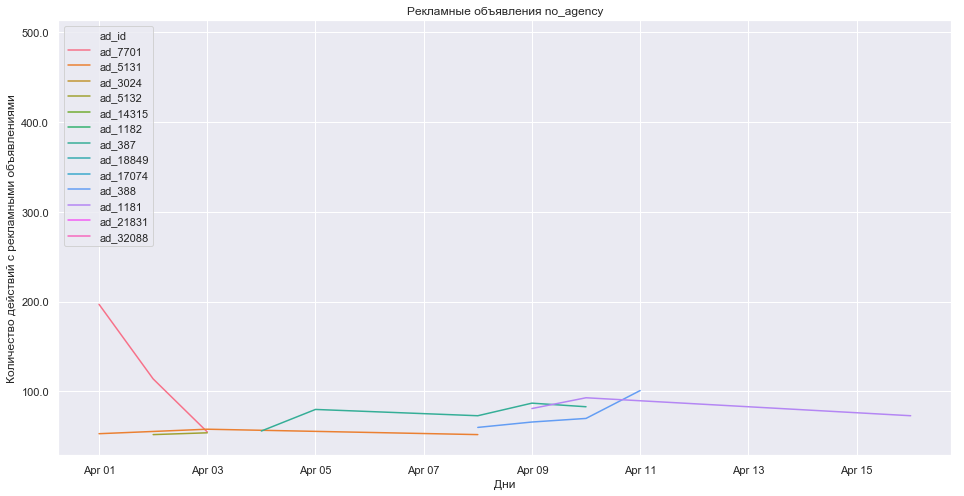

In [362]:
ax = sns.lineplot(x = 'date', y = 'event', hue = 'ad_id', data = df_no_agency)
ax.figure.set_size_inches(16, 8)
ax.set_title('Рекламные объявления no_agency')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

yfmt = tkr.FuncFormatter(y_fmt) 
ax.yaxis.set_major_formatter(yfmt)

In [307]:
#### плюс похоже, на старт новых реклам в эти дни и возможно они стрельнули, но не до конца??? 
#### построить графики начала-конца РК
df_agency_2 = df[df.agency_union_id == 'agency_2'].groupby(['date','ad_id'], as_index=False).\
agg({'event' : 'count'})

df_agency_2['date'] = pd.to_datetime(df_agency_2.date, format='%Y-%m-%d')

df_agency_2.sort_values(by = 'date', ascending=True, inplace=True)

In [308]:
df_agency_2.quantile(.70)

event    145.2
Name: 0.7, dtype: float64

In [309]:
#### drop ad_id, that are less than 1k in total
# use quantile maybe?
df_agency_2 = df_agency_2[df_agency_2.event > 150]

In [310]:
df_agency_2.head()

,date,ad_id,event
40,2019-04-08,ad_49564,1438
37,2019-04-08,ad_47269,151
39,2019-04-08,ad_49560,2940
46,2019-04-09,ad_49560,1867
47,2019-04-09,ad_49564,1012


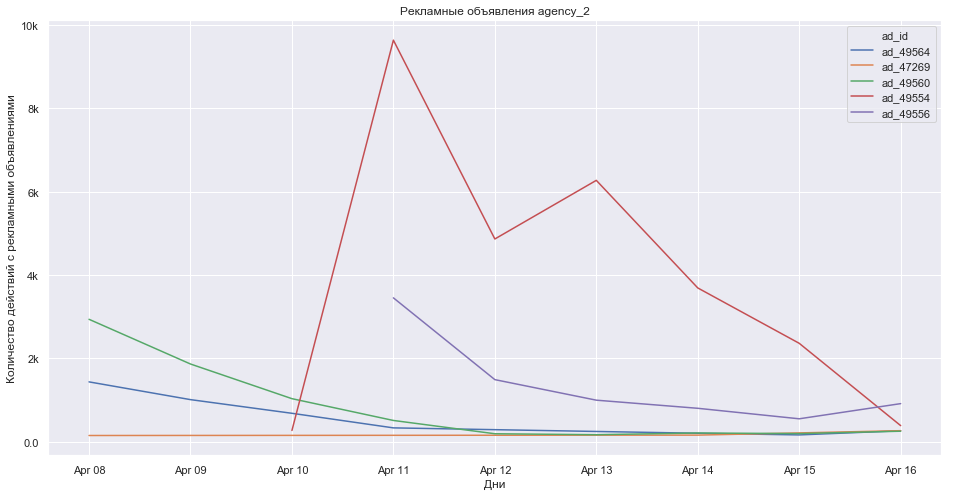

In [311]:
ax = sns.lineplot(x = 'date', y = 'event', hue = 'ad_id', data = df_agency_2)
ax.figure.set_size_inches(16, 8)
ax.set_title('Рекламные объявления agency_2')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

yfmt = tkr.FuncFormatter(y_fmt) 
ax.yaxis.set_major_formatter(yfmt)

Отдельно посмотрим на ad_49554

In [528]:
df_ctr = df[(df.campaign_union_id == 'campaign_1') & (df.ad_cost_type == 'CPC')]
df_ctr = df_ctr.groupby(['date','event'], as_index = False).count()
df_ctr['has_clicks'] = pd.Series(df_ctr.event == 'click').astype(int)
df_ctr['ctr'] = df_ctr.time / df_ctr.has_clicks

df_ctr.head(7)

,date,event,time,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp,has_clicks,ctr
0,2019-04-01,view,6,6,6,6,6,6,6,6,6,0,inf
1,2019-04-02,view,21,21,21,21,21,21,21,21,21,0,inf
2,2019-04-03,view,6,6,6,6,6,6,6,6,6,0,inf
3,2019-04-04,view,5,5,5,5,5,5,5,5,5,0,inf
4,2019-04-05,view,8,8,8,8,8,8,8,8,8,0,inf
5,2019-04-06,view,8,8,8,8,8,8,8,8,8,0,inf
6,2019-04-07,view,3,3,3,3,3,3,3,3,3,0,inf


In [582]:
#### ПОСЧИТАТЬ CTR, возможно больше бабок вбухали на рекламу
#### CTR считается по дням + рекламной компании
#df_ctr

# взять cpc, сгруппировать по дня, 
df_ctr = df[df.ad_cost_type == 'CPC'] #df[df.ad_id == 'ad_49554']

df_ctr = df_ctr.groupby(['campaign_union_id','event'], as_index=False).\
agg({'time' : 'count',
   
    })

df_ctr.sort_values(['campaign_union_id'], inplace=True)


In [583]:
df_ctr = df_ctr.pivot_table(index='campaign_union_id',
               columns='event',
               #values='campaign_union_id',
               aggfunc='sum').reset_index()

In [584]:
df_ctr.columns = df_ctr.columns.droplevel()
df_ctr.columns = ['campaign_union_id', 'click', 'report', 'view']

In [586]:
#df_ctr[df_ctr.view > 1]

In [589]:
df_ctr['ctr'] = df_ctr.click / df_ctr.view

In [590]:
df_ctr[df_ctr.campaign_union_id == 'campaign_49554']

,campaign_union_id,click,report,view,ctr
1957,campaign_49554,45.0,6.0,47688.0,0.000944


In [591]:
df_ctr.describe()

,click,report,view,ctr
count,918.000000,234.00000,1109.000000,52.000000
mean,1.821351,1.32906,65.120830,0.172237
std,3.876319,1.26298,1433.937362,0.321167
min,1.000000,1.00000,1.000000,0.000536
25%,1.000000,1.00000,2.000000,0.007288
50%,1.000000,1.00000,4.000000,0.020842
75%,1.000000,1.00000,14.000000,0.125000
max,63.000000,11.00000,47688.000000,1.000000


In [466]:
'''df_ctr = df_ctr.pivot_table(index='date',
               columns=['campaign_union_id','event'],
               values='time',
               aggfunc='count').reset_index()''';

In [390]:
df[df.ad_id == 'ad_49554'].shape

(27500, 11)

In [391]:
df[df.ad_id == 'ad_49554']['event'].value_counts()

view      27464
click        31
report        5
Name: event, dtype: int64

Выводы.

#### Отдельно 11 апреля.

In [186]:
df_splash_day = df[df.date == '2019-04-11']
print (df_splash_day.shape)

(18259, 11)


In [187]:
df_splash_day = df_splash_day.sort_values(by = 'time_from_timestamp')
df_splash_day.drop(['has_video','date'], axis = 1, inplace = True)
df_splash_day.reset_index(inplace=True,drop=True)

In [188]:
df_splash_day.head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
0,1554940810,view,CPC,agency_33,client_99583,campaign_99643,ad_99643,web,2019-04-11 00:00:10
1,1554940815,view,CPM,agency_158,client_106198,campaign_106664,ad_106668,android,2019-04-11 00:00:15
2,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18
3,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40
4,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47


In [101]:
for column in df_splash_day.drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df_splash_day[column].value_counts()[:5])

view      16097
click      1811
report      351
Name: event, dtype: int64
CPC    15383
CPM     2876
Name: ad_cost_type, dtype: int64
agency_2      14035
no_agency      2691
agency_158      105
agency_29        90
agency_33        81
Name: agency_union_id, dtype: int64
client_47270    13941
client_6          143
client_47269       92
client_99239       85
client_42          77
Name: client_union_id, dtype: int64
campaign_49554    13941
campaign_387        143
campaign_47269       79
campaign_99242       73
campaign_5822        62
Name: campaign_union_id, dtype: int64
ad_49554    9640
ad_49556    3455
ad_49560     512
ad_49564     334
ad_388       101
Name: ad_id, dtype: int64
android    12945
iphone      2141
web         1885
mvk         1271
wphone        17
Name: platform, dtype: int64


In [207]:
df_splash_day[df_splash_day.agency_union_id == 'agency_2'].groupby(['ad_cost_type','platform'], as_index=False).\
agg({'event' : 'count'})

,ad_cost_type,platform,event
0,CPC,android,10160
1,CPC,iphone,1501
2,CPC,mvk,1064
3,CPC,web,1308
4,CPM,android,2


Похоже наибольшее количество событий за этот день составляют вида CPC- view, с agency_2, client_47270, campaign_49554, ad_49554 и ad_49556.

Построим таймлайн с распределением событий в течение дня.

In [45]:
df_splash_hour_index = df_splash_day.set_index(df_splash_day.time_from_timestamp.dt.hour)
df_splash_hour_index.head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
time_from_timestamp,,,,,,,,,
0,1554940810,view,CPC,agency_33,client_99583,campaign_99643,ad_99643,web,2019-04-11 00:00:10
0,1554940815,view,CPM,agency_158,client_106198,campaign_106664,ad_106668,android,2019-04-11 00:00:15
0,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18
0,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40
0,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47


Сгруппируем и посмотрим в виде таймлайна на события.

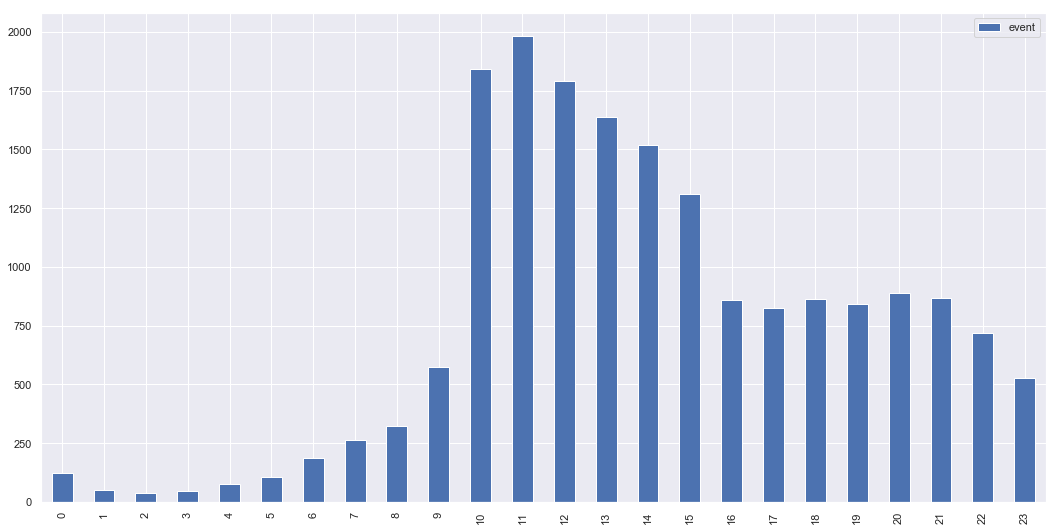

In [46]:
df_splash_hour_index.groupby(df_splash_hour_index.index, as_index=False)\
.agg({'event' : 'count'}).plot(kind = 'bar')

Самыми активными были часы 10:15.

Попробуем выделить паттерны/дубликаты.

In [47]:
# find fraud by timeout pattern
# try to get time diff with rollings?
df_splash_hour_index[(df_splash_hour_index.index == 10) & (df_splash_hour_index.platform == 'web')].head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
time_from_timestamp,,,,,,,,,
10,1554976804,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,web,2019-04-11 10:00:04
10,1554976822,click,CPC,no_agency,client_24724,campaign_40085,ad_40087,web,2019-04-11 10:00:22
10,1554976881,view,CPC,no_agency,client_42,campaign_5822,ad_6308,web,2019-04-11 10:01:21
10,1554976882,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,web,2019-04-11 10:01:22
10,1554976885,view,CPC,agency_2,client_47270,campaign_49554,ad_49560,web,2019-04-11 10:01:25


In [48]:
df_splash_hour_index.head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
time_from_timestamp,,,,,,,,,
0,1554940810,view,CPC,agency_33,client_99583,campaign_99643,ad_99643,web,2019-04-11 00:00:10
0,1554940815,view,CPM,agency_158,client_106198,campaign_106664,ad_106668,android,2019-04-11 00:00:15
0,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18
0,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40
0,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47


In [378]:
df_splash_hour_index[df_splash_hour_index.index == 0].head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp,diff
time_from_timestamp,,,,,,,,,,
0,1554940810,view,CPC,agency_33,client_99583,campaign_99643,ad_99643,web,2019-04-11 00:00:10,NaN
0,1554940815,view,CPM,agency_158,client_106198,campaign_106664,ad_106668,android,2019-04-11 00:00:15,5.0
0,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18,3.0
0,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40,22.0
0,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47,7.0


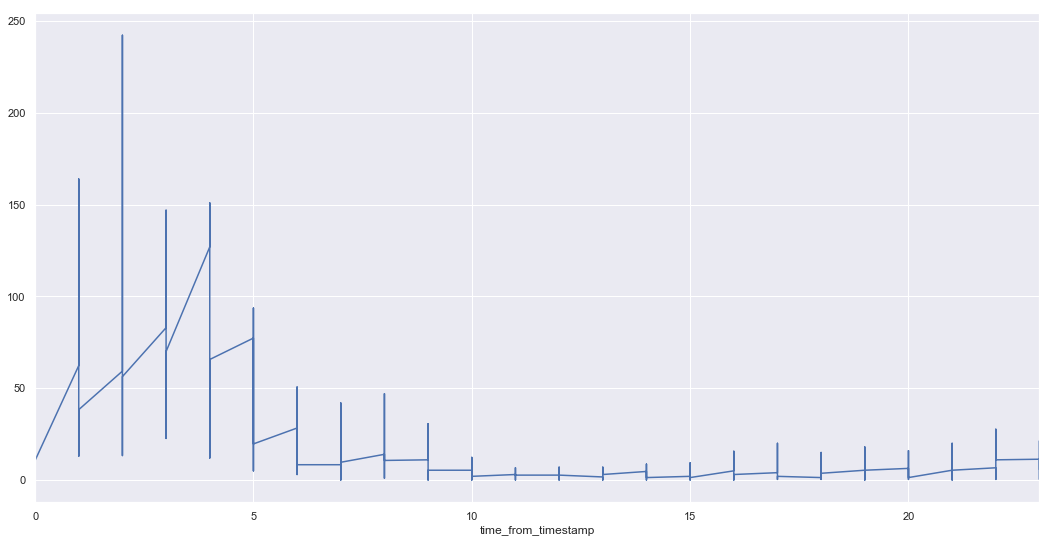

In [49]:
# rolling in pandas?
df_splash_hour_index['diff'] = df_splash_hour_index.time_from_timestamp.diff(periods = 1)
df_splash_hour_index['diff'] = df_splash_hour_index['diff'].astype('timedelta64[s]')

df_splash_hour_index['diff'].rolling(3, min_periods = 1).mean().plot(kind = 'line')

# try to use 
# df.ewm(alpha=.7).mean().head()
# or
# df.expanding(3).mean().head()

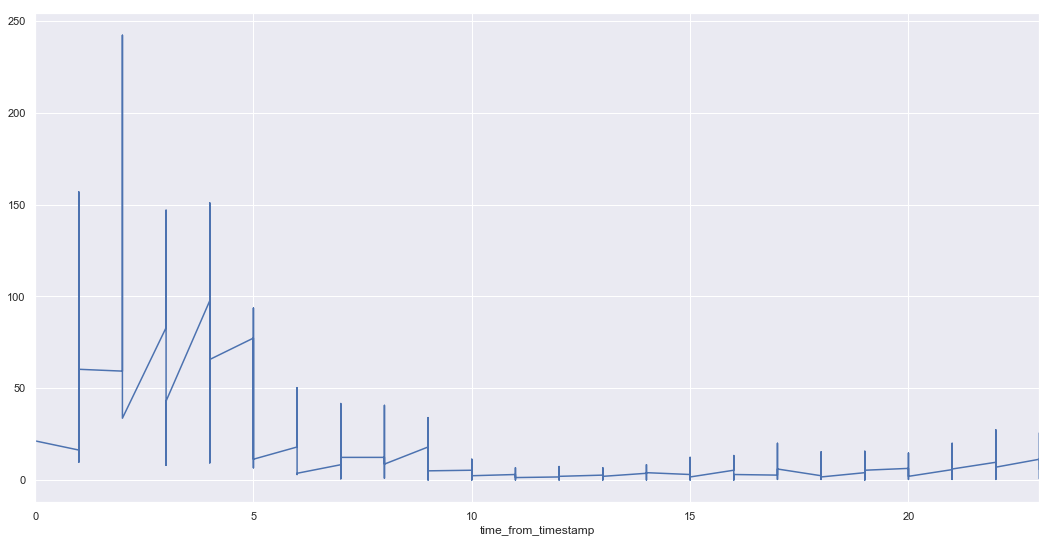

In [80]:
df_splash_hour_index[('diff')][df_splash_hour_index.platform == 'android'].rolling(3, min_periods = 1).mean().plot()

In [50]:
# df[df.agency_union_id == 'agency_2'].groupby(['date','event'],as_index=False).agg({'ad_cost_type':'count'})

In [51]:
bad_data = df_splash_day[(df_splash_day.agency_union_id =='agency_2') & (df_splash_day.campaign_union_id == 'campaign_49554')]

In [52]:
bad_data[bad_data.duplicated(subset=None, keep='first')]

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
10,1554940915,view,CPC,agency_2,client_47270,campaign_49554,ad_49560,iphone,2019-04-11 00:01:55
1515,1554976211,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,web,2019-04-11 09:50:11
1535,1554976308,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11 09:51:48
1567,1554976384,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,web,2019-04-11 09:53:04
1584,1554976422,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11 09:53:42
1593,1554976444,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11 09:54:04
1610,1554976487,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,iphone,2019-04-11 09:54:47
1615,1554976499,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,iphone,2019-04-11 09:54:59
1631,1554976525,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11 09:55:25
1638,1554976539,view,CPC,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11 09:55:39


In [53]:
for column in df_splash_day[df_splash_day.agency_union_id =='agency_2'].drop(['time', 'date', 'time_from_timestamp'], axis = 1): 
    print(df_splash_day[column].value_counts()[:3])

KeyError: "['date'] not found in axis"

In [ ]:
# better plot by day
df.ad_cost_type.value_counts().plot(kind='bar', color='blue')
df_splash_day.ad_cost_type.value_counts().plot(kind='bar',color='red')

In [ ]:
df_splash_day.has_video.value_counts()